# Comparison of performance and temperature evolutions on Dahu

In [1]:
import io
import zipfile
import pandas
import yaml
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    info = get_yaml(archive_name, 'info.yaml')
    hostname = [k for k in info if k.endswith('grid5000.fr')]
    assert len(hostname) == 1
    idx = hostname[0].index('.')
    hostname = hostname[0][:idx]
    idx = hostname.index('-')
    node = int(hostname[idx+1:])
    result['hostname'] = hostname
    result['node'] = node
    result['jobid'] = info['jobid']
    result['filename'] = archive_name
    result['start'] = pandas.to_datetime(result['start'])
    result['stop'] = pandas.to_datetime(result['stop'])
    return result

def read_result(name, exp_id=0):
    perf = read_csv(name, 'stress_perf_%d.csv' % exp_id)
    temp = read_csv(name, 'stress_temp_%d.csv' % exp_id)
    min_time = min(perf.start.min(), temp.start.min())
    for df in [perf, temp]:
        for name in ['start', 'stop']:
            df[name] -= min_time
    return perf, temp

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

directory = 'data/1/'
exp_files = [directory + filename for filename in os.listdir(directory)]
results = [read_result(filename) for filename in exp_files]

perf = pandas.concat([t[0] for t in results])
temp = pandas.concat([t[1] for t in results])
perf.head()

,start,stop,duration,gflops,index,hostname,node,jobid,filename
0,00:00:00.000216,00:00:11.700618,11.700368,751.779166,0,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
1,00:00:11.700938,00:00:23.474666,11.773699,747.096827,1,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
2,00:00:23.474965,00:00:35.315130,11.840136,742.904710,2,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
3,00:00:35.315428,00:00:47.132701,11.817246,744.343737,3,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
4,00:00:47.132998,00:00:59.040253,11.907227,738.718861,4,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip


In [2]:
temp.head()

,start,stop,sensor_id,temperature,index,hostname,node,jobid,filename
0,00:00:00,00:00:00.000167,0,50.0,0,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
1,00:00:00,00:00:00.000167,1,61.0,1,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
2,00:00:11.700746,00:00:11.700915,0,56.0,2,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
3,00:00:11.700746,00:00:11.700915,1,71.0,3,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip
4,00:00:23.474775,00:00:23.474943,0,58.0,4,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip


## Visualizing the data

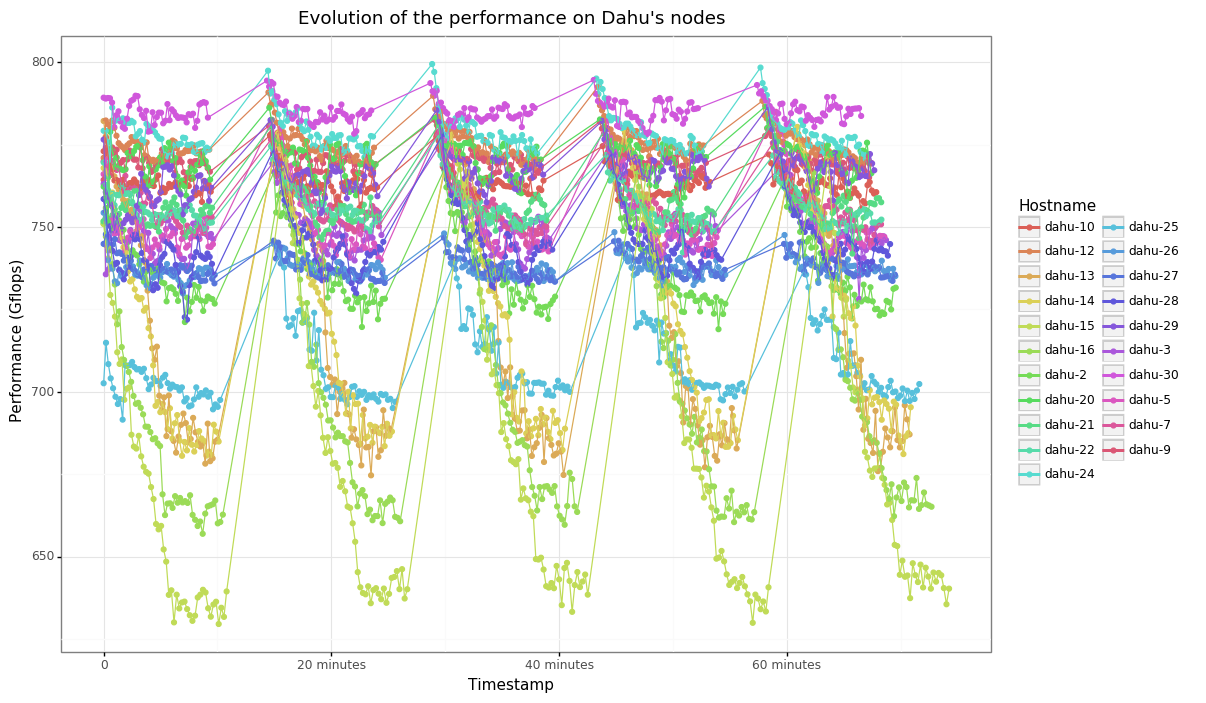

<ggplot: (-9223363269436770963)>

In [3]:
plot = ggplot(perf, aes(x='start', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw()
plot + xlab('Timestamp') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Evolution of the performance on Dahu's nodes")

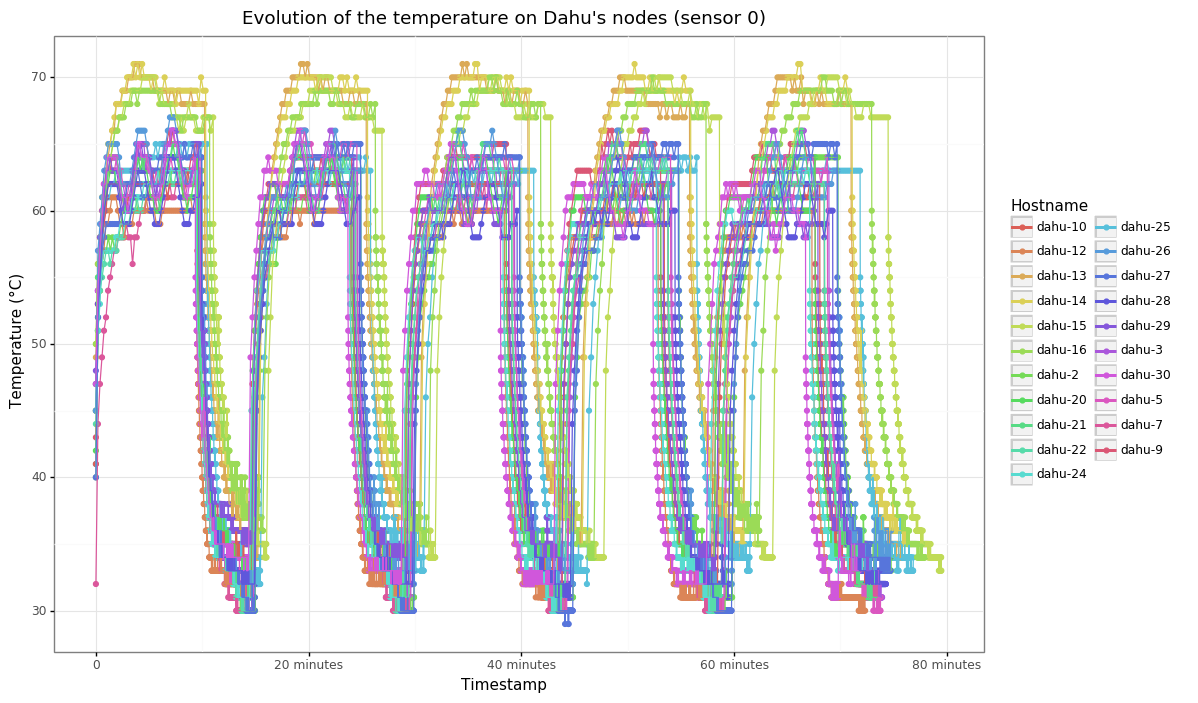

<ggplot: (8767417958955)>


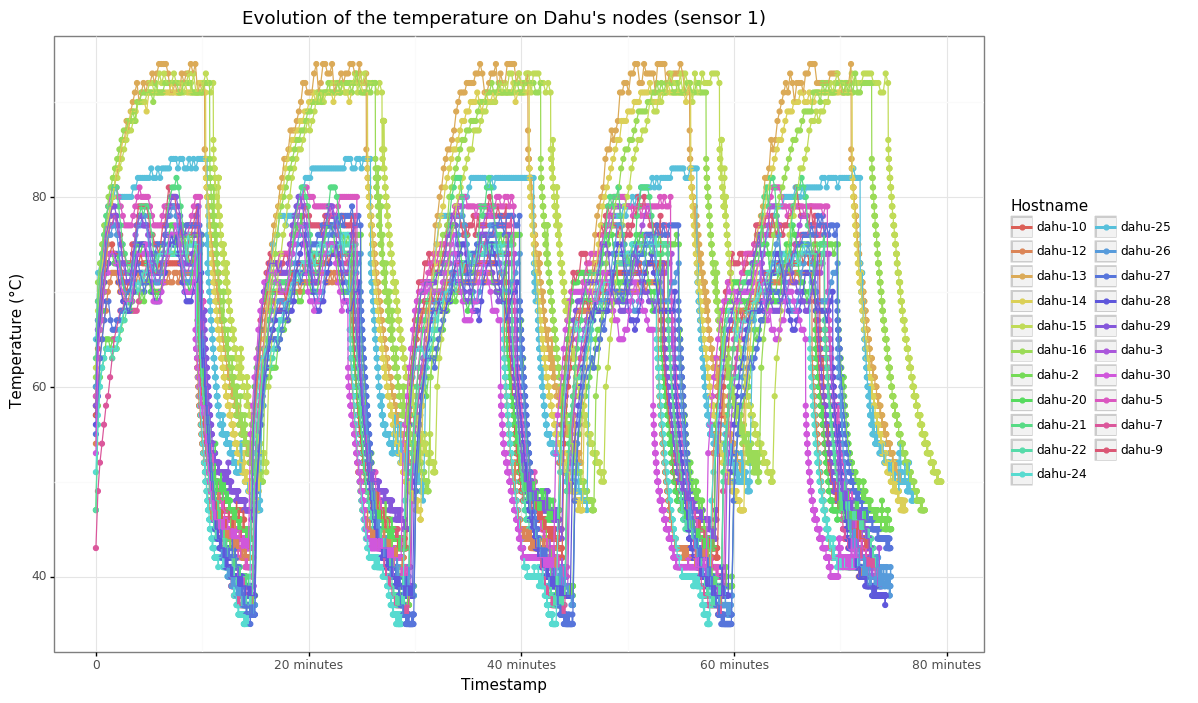

<ggplot: (-9223363269438075192)>


In [4]:
for sensor in temp.sensor_id.unique():
    plot = ggplot(temp[temp.sensor_id == sensor], aes(x='start', y='temperature', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw()
    plot = plot + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='Hostname') + ggtitle("Evolution of the temperature on Dahu's nodes (sensor %d)" % sensor)
    print(plot)

In [5]:
def compute_avg_temp(perf_df, temp_df, sensor_id=1):
    new_perf = []
    for host in perf_df.hostname.unique():
        perf = perf_df[perf_df.hostname == host].copy()
        perf['kind'] = 'perf'
        temp = temp_df[(temp_df.hostname == host) & (temp_df.sensor_id==sensor_id)].copy()
        temp['kind'] = 'temp'
        df = pandas.concat([perf, temp]).sort_values(by='start').reset_index(drop=True)
        idx = df[df.kind == 'perf'].index
        perf['temp_before'] = df.iloc[idx-1].temperature.reset_index(drop=True)
        perf['temp_after'] = df.iloc[idx+1].temperature.reset_index(drop=True)
        perf['avg_temp'] = (perf.temp_before + perf.temp_after)/2
        new_perf.append(perf)
    return pandas.concat(new_perf)

In [6]:
df = compute_avg_temp(perf, temp)
df.head()

,start,stop,duration,gflops,index,hostname,node,jobid,filename,kind,temp_before,temp_after,avg_temp
0,00:00:00.000216,00:00:11.700618,11.700368,751.779166,0,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip,perf,61.0,71.0,66.0
1,00:00:11.700938,00:00:23.474666,11.773699,747.096827,1,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip,perf,71.0,73.0,72.0
2,00:00:23.474965,00:00:35.315130,11.840136,742.904710,2,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip,perf,73.0,75.0,74.0
3,00:00:35.315428,00:00:47.132701,11.817246,744.343737,3,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip,perf,75.0,77.0,76.0
4,00:00:47.132998,00:00:59.040253,11.907227,738.718861,4,dahu-16,16,1859950,data/1/grenoble_2019-04-15_1859950.zip,perf,77.0,77.0,77.0


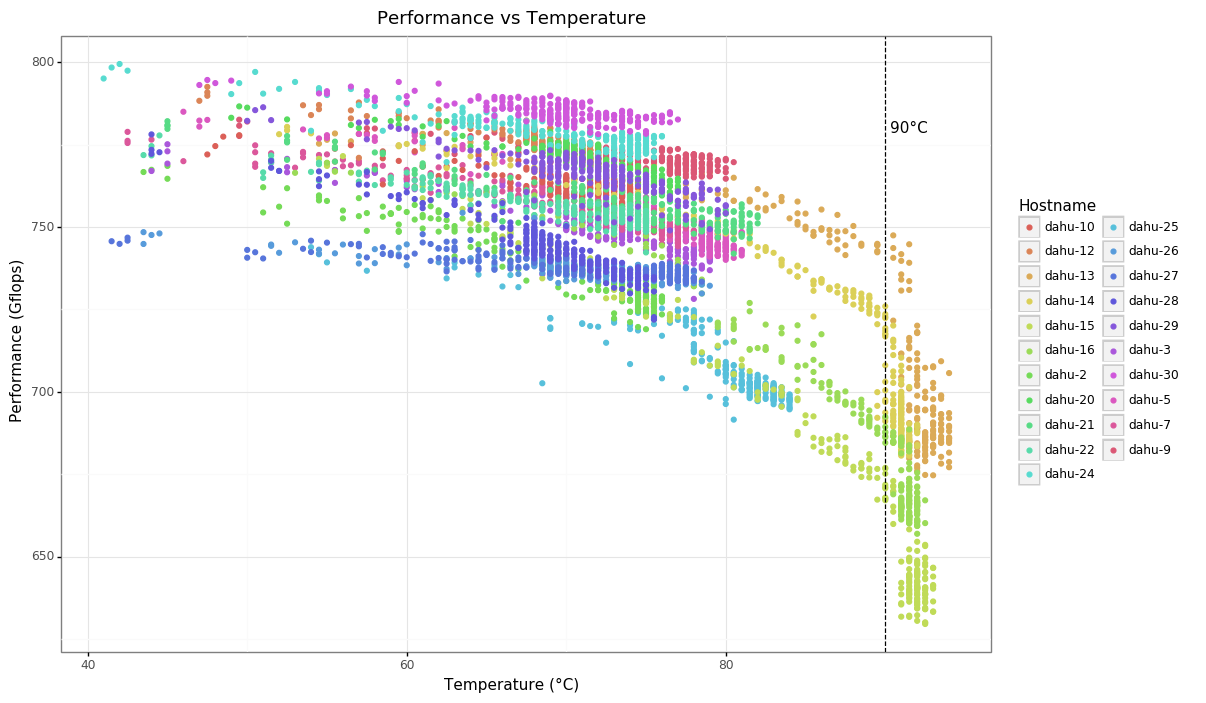

<ggplot: (8767418004940)>

In [7]:
plot = ggplot(df, aes(x='avg_temp', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + theme_bw()
plot = plot + xlab('Temperature (°C)') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Performance vs Temperature")
plot = plot + geom_vline(xintercept=90, linetype='dashed') + annotate('text', label='90°C', x=91.5, y=780)
plot

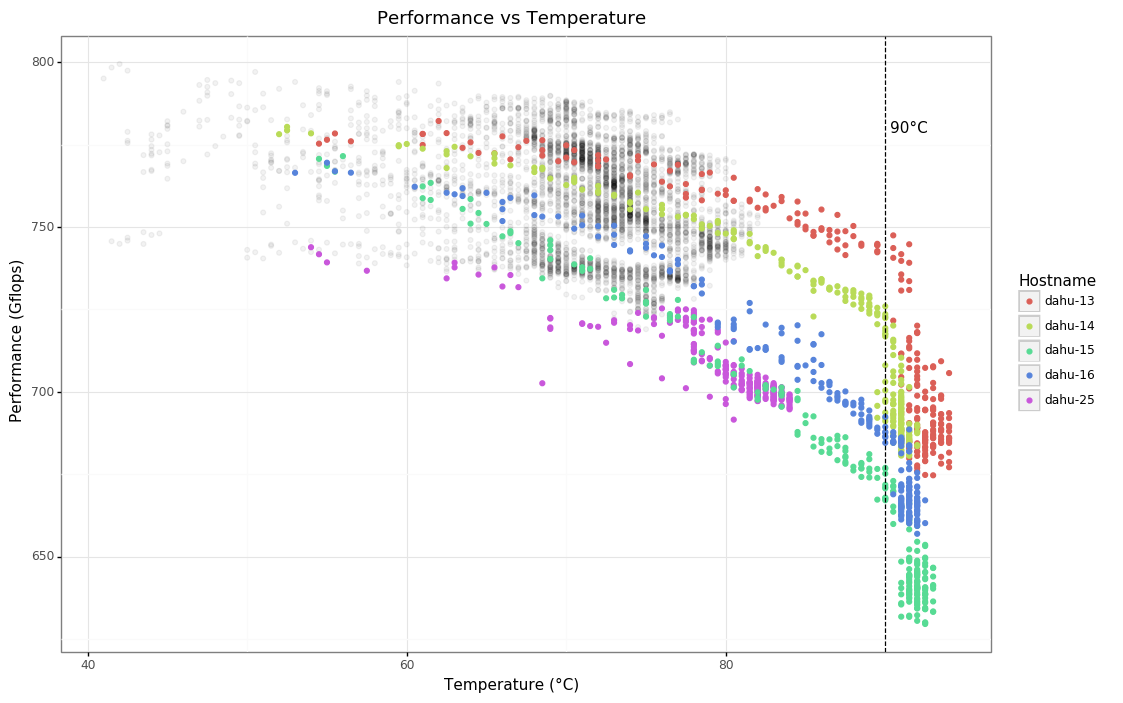

<ggplot: (-9223363269436809479)>

In [8]:
plot = ggplot(aes(x='avg_temp', y='gflops', color='factor(hostname)', group='jobid')) + theme_bw()
plot = plot + geom_point(df[~df.node.isin([13, 14, 15, 16, 25])], color='black', alpha=0.05) + geom_point(df[df.node.isin([13, 14, 15, 16, 25])])
plot = plot + xlab('Temperature (°C)') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Performance vs Temperature")
plot = plot + geom_vline(xintercept=90, linetype='dashed') + annotate('text', label='90°C', x=91.5, y=780)
plot

## Correlation coefficients for temperature & performance

In [9]:
cor_coeff = df.groupby('node')[['avg_temp', 'gflops']].corr().iloc[0::2,-1]  # using https://stackoverflow.com/a/28990872/4110059
print(cor_coeff)
print()
cor_coeff.describe()

node          
2     avg_temp   -0.942031
3     avg_temp   -0.895005
5     avg_temp   -0.930449
7     avg_temp   -0.933126
9     avg_temp   -0.706945
10    avg_temp   -0.682489
12    avg_temp   -0.845429
13    avg_temp   -0.838585
14    avg_temp   -0.881521
15    avg_temp   -0.952815
16    avg_temp   -0.940830
20    avg_temp   -0.758039
21    avg_temp   -0.915001
22    avg_temp   -0.923063
24    avg_temp   -0.892076
25    avg_temp   -0.866447
26    avg_temp   -0.776881
27    avg_temp   -0.796106
28    avg_temp   -0.942840
29    avg_temp   -0.827754
30    avg_temp   -0.715753
Name: gflops, dtype: float64



count    21.000000
mean     -0.855390
std       0.085792
min      -0.952815
25%      -0.930449
50%      -0.881521
75%      -0.796106
max      -0.682489
Name: gflops, dtype: float64